# Solution Check: Davies-Jones (2008) vs. Saunders (1957)

In [186]:
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units, concatenate
import metpy.constants as const
import matplotlib.pyplot as plt

import sys
sys.path.append('../scripts/')
from thermo import moist_lapse, saturation_specific_humidity, theta_e

In [133]:
def _daviesjones_f(Tw, pi, Q=None, kind='pseudo'):
    """
    Evaluates the function f defined in eq. 2.3 of Davies-Jones 2008.

    Args:
        Tw: Wet-bulb temperature in KELVIN.
        pi: Nondimensional pressure.
        Q: total mixing ratio of all phases of water (only needed for
            reversible adiabats).
        kind: 'pseudo' for pseudoadiabats and 'reversible' for
            reversible adiabats.

    Returns:
        The value of f(Tw, pi).
    """
    
    cp = const.dry_air_spec_heat_press.m
    R = const.dry_air_gas_constant.m
    lambda_ = cp/R
    pressure = 1000.0 * pi**lambda_  # in mbar

    # coefficients
    C = 273.15
    if kind == 'pseudo':
        k0 = 3036
        k1 = 1.78
        k2 = 0.448
        nu = 0.2854  # poisson constant for dry air
    elif kind == 'reversible':
        if Q is None:
            raise ValueError(
                'Total water mixing ratio Q must be supplied for '
                'reversible adiabats.')
        L0 = 2.501e6
        L1 = 2.37e3
        cpd = const.dry_air_spec_heat_press.m
        # cw = 4190.  # specific heat of liquid water
        cw = const.water_specific_heat.m*1e3
        k0 = (L0 + L1*C)/(cpd + cw*Q)
        k1 = L1/(cpd + cw*Q)
        k2 = 0
        nu = const.dry_air_gas_constant.m/(cpd + cw*Q)
    else:
        raise ValueError("kind must be 'pseudo' or 'reversible'.")
        
    # saturation mixing ratio and vapour pressure calculated using
    # eq. 10 of Bolton 1980
    rs = mpcalc.saturation_mixing_ratio(
        pressure*units.mbar, Tw*units.kelvin).m_as(units.dimensionless)
    es = mpcalc.saturation_vapor_pressure(Tw*units.kelvin).m_as(units.mbar)

    G = (k0/Tw - k1)*(rs + k2*rs**2)
    f = (C/Tw)**lambda_ * (1 - es/pressure)**(lambda_*nu) * np.exp(-lambda_*G)

    return f


def _daviesjones_fprime(tau, pi, Q=None, kind='pseudo'):
    """
    Evaluates df/dtau (pi fixed) defined in eqs. A.1-A.5 of Davies-Jones 2008.

    Args:
        tau: Temperature in KELVIN.
        pi: Nondimensional pressure.
        Q: total mixing ratio of all phases of water (only needed for
            reversible adiabats).
        kind: 'pseudo' for pseudoadiabats and 'reversible' for
            reversible adiabats.

    Returns:
        The value of f'(Tau, pi) for fixed pi.
    """
    
    cp = const.dry_air_spec_heat_press.m
    R = const.dry_air_gas_constant.m
    lambda_ = cp/R
    pressure = 1000.0 * pi**lambda_  # in mbar

    # coefficients
    C = 273.15
    epsilon = 0.6220
    if kind == 'pseudo':
        k0 = 3036
        k1 = 1.78
        k2 = 0.448
        nu = 0.2854  # poisson constant for dry air
    elif kind == 'reversible':
        if Q is None:
            raise ValueError(
                'Total water mixing ratio Q must be supplied for '
                'reversible adiabats.')
        L0 = 2.501e6
        L1 = 2.37e3
        cpd = const.dry_air_spec_heat_press.m
        # cw = 4190.  # specific heat of liquid water
        cw = const.water_specific_heat.m*1e3
        k0 = (L0 + L1*C)/(cpd + cw*Q)
        k1 = L1/(cpd + cw*Q)
        k2 = 0
        nu = const.dry_air_gas_constant.m/(cpd + cw*Q)
    else:
        raise ValueError("kind must be 'pseudo' or 'reversible'.")

    # saturation mixing ratio and vapour pressure calculated using
    # eq. 10 of Bolton 1980
    rs = mpcalc.saturation_mixing_ratio(
        pressure*units.mbar, tau*units.kelvin).m_as(units.dimensionless)
    es = mpcalc.saturation_vapor_pressure(tau*units.kelvin).m_as(units.mbar)

    des_dtau = es*17.67*243.5/(tau - C + 243.5)**2  # eq. A.5
    drs_dtau = epsilon*pressure/(pressure - es)**2 * des_dtau  # eq. A.4
    dG_dtau = (-k0/tau**2 * (rs + k2*rs**2)
               + (k0/tau - k1)*(1 + 2*k2*rs)*drs_dtau)  # eq. A.3
    dlogf_dtau = -lambda_*(1/tau + nu/(pressure - es)*des_dtau
                         + dG_dtau)  # eq. A.2
    df_dtau = _daviesjones_f(tau, pi) * dlogf_dtau  # eq. A.1

    return df_dtau

In [135]:
def reversible_lapse_daviesjones(
        pressure, initial_temperature, initial_liquid_ratio,
        reference_pressure=None, improve=2):
    """
    Computes temperature along reversible adiabats.
    
    Uses the method of Davies-Jones (2008).
    
    Args:
        pressure: Array of pressures for which the temperature is to
            be found.
        initial_temperature: Initial parcel temperature.
        q_initial: Initial specific humidity.
        initial_liquid_ratio: Initial ratio of liquid mass to total.
        reference_pressure: The pressure corresponding to
            initial_temperature. Optional, defaults to pressure[0].
        improve: Number of iterations of Newton's method to execute.
    
    Returns:
        Array of final temperatures.
    """
    
    pressure = np.atleast_1d(pressure).m_as(units.mbar)
    if reference_pressure is None:
        reference_pressure = pressure[0]
    else:
        reference_pressure = reference_pressure.m_as(units.mbar)
    
    cp = const.dry_air_spec_heat_press.m
    R = const.dry_air_gas_constant.m
    lambda_ = cp/R
    # nondimensional pressure
    reference_pi = (reference_pressure/1000.0)**(1./lambda_)
    C = 273.15
    # initial specific humidity is saturated specific humidity
    q_initial = saturation_specific_humidity(
        pressure[0]*units.mbar, initial_temperature).m
    # total mixing ratio (liquid + vapour)
    Q = ((q_initial + initial_liquid_ratio)
         /(1 - q_initial - initial_liquid_ratio))
    if hasattr(Q, 'units'):
        Q = Q.m_as(units.dimensionless)  # make sure Q is a number
    cpd = const.dry_air_spec_heat_press.m
    # cw = 4190.  # specific heat of liquid water
    cw = const.water_specific_heat.m*1e3
    nu = const.dry_air_gas_constant.m/(cpd + cw*Q)
        
    # see eq. 5.3 of Davies-Jones 2008
    f_initial = _daviesjones_f(
        initial_temperature.m_as(units.kelvin), reference_pi, Q=Q,
        kind='reversible')
    A1 = f_initial**(-1/lambda_)*C/reference_pi**(lambda_*nu)
    
    def single(p):
        """Finds the final temperature for a single pressure value."""
        
        # initial guess using pseudoadiabat
        temperature = moist_lapse(
            p*units.mbar, initial_temperature,
            reference_pressure*units.mbar, method='fast',
            improve=False).m_as(units.celsius)

        pi = (p/1000.0)**(1./lambda_)
        X = (C/(A1*pi**(lambda_*nu)))**lambda_  # correction
        for i in range(improve):
            # apply iterations of Newton's method (eq. 2.6)
            slope = _daviesjones_fprime(
                temperature + C, pi, Q=Q, kind='reversible')
            fvalue = _daviesjones_f(
                temperature + C, pi, Q=Q, kind='reversible')
            temperature = temperature - (fvalue - X)/slope
        
        return temperature
        
    return ([single(p) for p in pressure] if pressure.size > 1
            else single(pressure.item()))*units.celsius


def reversible_lapse_saunders(
        pressure, t_initial, l_initial, reference_pressure=None, improve=2):
    """
    Calculates temperature along reversible adiabats.
    
    Uses Eq. 3 of Saunders (1957).
    
    Args:
        pressure: Pressure array.
        t_initial: Initial temperature.
        l_initial: Initial ratio of liquid mass to total
        reference_pressure: Pressure corresponding to t_inital.
        improve: Number of Newton's method iterations to use.
        
    Returns:
        Resultant temperature array.
    """
    
    pressure = np.atleast_1d(pressure).m_as(units.mbar)
    if reference_pressure is None:
        reference_pressure = pressure[0]
    else:
        reference_pressure = reference_pressure.m_as(units.mbar)
        
    t_initial = t_initial.m_as(units.kelvin)
    if hasattr(l_initial, 'units'):
        l_initial = l_initial.m_as(units.dimensionless)
    
    # constants
    cp = const.dry_air_spec_heat_press.m
    cw = const.water_specific_heat.m*1e3
    R = const.dry_air_gas_constant.m
    C = 273.15
    e0 = 6.112
    a = 17.67
    b = 243.5
    epsilon = const.epsilon.m
    L0 = 2.501e6
    L1 = 2.37e3
    
    # total vapour + liquid water mixing ratio (invariant)
    q_initial = saturation_specific_humidity(
        reference_pressure*units.mbar, t_initial*units.kelvin).m
    r = (q_initial + l_initial)/(1 - q_initial - l_initial)
    
    def saunders_function(p, t):
        """Evaluates the LHS of Eq. 3 and its derivative w.r.t. temperature"""
        
        # saturation vapour pressure and derivative
        es = e0*np.exp(a*(t - C)/(t - C + b))
        des_dt = a*b/(t - C + b)**2 * es
        
        # saturation (vapour) mixing ratio and derivative
        rw = epsilon*es/(p - es)
        drw_dt = epsilon*p*des_dt/(p - es)**2
        
        # latent heat of vapourisation of water and derivative
        Lv = L0 - L1*(t - C)
        dLv_dt = -L1
        
        # LHS of Eq. 3 and derivative
        fvalue = (cp + r*cw)*np.log(t) + rw*Lv/t - R*np.log(p - es)
        fprime = ((cp + r*cw)/t + (t*(drw_dt*Lv + rw*dLv_dt) - rw*Lv)/t**2
                  + R*des_dt/(p - es))
        
        return fvalue, fprime
    
    # RHS of Eq. 3
    A, _ = saunders_function(reference_pressure, t_initial)
    
    # initial guess: pseudoadiabatic values
    t_final = moist_lapse(
        pressure*units.mbar, t_initial*units.kelvin,
        reference_pressure*units.mbar).m_as(units.kelvin)
    
    # apply Newton's method
    for i in range(improve):
        fvalue, fprime = saunders_function(pressure, t_final)
        t_final = t_final - (fvalue - A)/fprime
    
    return t_final*units.kelvin

In [191]:
def moist_lapse(
        pressure, initial_temperature, reference_pressure=None,
        method='integration', improve=True):
    """
    Computes temperature from pressure along pseudoadiabats.
    
    Args:
        pressure: Array of pressures for which the temperature is to
            be found.
        initial_temperature: Initial parcel temperature.
        reference_pressure: The pressure corresponding to
            initial_temperature. Optional, defaults to pressure[0].
        method: 'integration' for the MetPy method, 'fast' for
            the Davies-Jones (2008) method.
        improve: Whether or not to apply an iteration of Newton's
            method (only relevant for method == 'fast').
    
    Returns:
        Array of final temperatures.
    """
    
    pressure = np.atleast_1d(pressure)
    if reference_pressure is None:
        reference_pressure = pressure[0]
    if method == 'integration':
        if pressure.size == 1:
            try:
                temperature = mpcalc.moist_lapse(
                    pressure, initial_temperature,
                    reference_pressure=reference_pressure)
                return np.atleast_1d(temperature)[0]
            except:
                return mpcalc.moist_lapse(
                    pressure.item(), initial_temperature.item(),
                    reference_pressure=reference_pressure.item())
        else:
            pressure = pressure[1:]
            temperature = mpcalc.moist_lapse(
                pressure, initial_temperature,
                reference_pressure=reference_pressure)
            return concatenate([initial_temperature, temperature])
    elif method == 'fast':
        q_initial = saturation_specific_humidity(
            reference_pressure, initial_temperature)
        # find initial theta-e (equal to final theta-e)
        thetae_conserved = theta_e(
            reference_pressure, initial_temperature, q_initial)
        # final temperature is equal to final wet bulb temperature
        temperature = concatenate([
            wetbulb(p, thetae_conserved, improve) for p in pressure
        ])
        if temperature.size == 1:
            return temperature.item()
        else:
            return temperature
    else:
        raise ValueError("method must be 'fast' or 'integration'.")

In [190]:
def wetbulb(pressure, theta_e, improve=True):
    """
    Calculates wet bulb temperature using the method in Davies-Jones 2008.

    Args:
        pressure: Pressure.
        theta_e: Equivalent potential temperature.
        improve: Whether or not to perform a single iteration of
            Newton's method to improve accuracy (defaults to False).

    Returns:
        Wet bulb temperature.
    """

    # changing to correct units
    pressure = pressure.m_as(units.mbar)
    theta_e = theta_e.m_as(units.kelvin)
    
    cp = const.dry_air_spec_heat_press.m
    R = const.dry_air_gas_constant.m
    lambda_ = cp/R
    pi = (pressure/1000.0)**(1./lambda_)
    Teq = theta_e*pi
    C = 273.15
    X = (C/Teq)**lambda_

    # slope and intercept for guesses - eq. 4.3, 4.4
    k1 = -38.5*pi**2 + 137.81*pi - 53.737
    k2 = -4.392*pi**2 + 56.831*pi - 0.384

    # transition point between approximation schemes - eq. 4.7
    D = 1/(0.1859*pressure/1000 + 0.6512)

    # initial guess
    if X > D:
        A = 2675.0
        # saturation mixing ratio calculated via vapour pressure using
        # eq. 10 of Bolton 1980
        rs = mpcalc.saturation_mixing_ratio(
            pressure*units.mbar, Teq*units.kelvin).m_as(units.dimensionless)
        # d(log(e_s))/dT calculated also from eq. 10, Bolton 1980
        d_log_es_dt = 17.67*243.5/(Teq + 243.5)**2

        # approximate wet bulb temperature in celsius
        Tw = Teq - C - A*rs/(1 + A*rs*d_log_es_dt)
    elif 1 <= X <= D:
        Tw = k1 - k2*X
    elif 0.4 <= X < 1:
        Tw = (k1 - 1.21) - (k2 - 1.21)*X
    else:
        Tw = (k1 - 2.66) - (k2 - 1.21)*X + 0.58/X

    if improve:
        # execute a single iteration of Newton's method (eq. 2.6)
        slope = _daviesjones_fprime(Tw + C, pi)
        fvalue = _daviesjones_f(Tw + C, pi)
        Tw = Tw - (fvalue - X)/slope

    return Tw*units.celsius

In [171]:
# pressure = np.arange(900, 99, -10)*units.mbar
# t_initial = np.arange(-10, 41, 1)*units.celsius
pressure = np.arange(900, 99, -10)*units.mbar
t_initial = np.arange(-5, 41, 1)*units.celsius

t_dj = np.zeros((pressure.size, t_initial.size))
for i, t in enumerate(t_initial):
    t_dj[:,i] = reversible_lapse_daviesjones(pressure, t, 0, improve=10).m
t_dj = t_dj*units.celsius

t_s = np.zeros((pressure.size, t_initial.size))
for i, t in enumerate(t_initial):
    t_s[:,i] = reversible_lapse_saunders(pressure, t, 0, improve=10).m
t_s = t_s*units.kelvin

In [192]:
t_pseudo = np.zeros((pressure.size, t_initial.size))
for i, t in enumerate(t_initial):
    t_pseudo[:,i] = moist_lapse(pressure, t).m
t_pseudo = t_pseudo*units.celsius

In [193]:
t_pseudo_fast = np.zeros((pressure.size, t_initial.size))
for i, t in enumerate(t_initial):
    t_pseudo_fast[:,i] = moist_lapse(pressure, t, method='fast').m
t_pseudo_fast = t_pseudo_fast*units.celsius

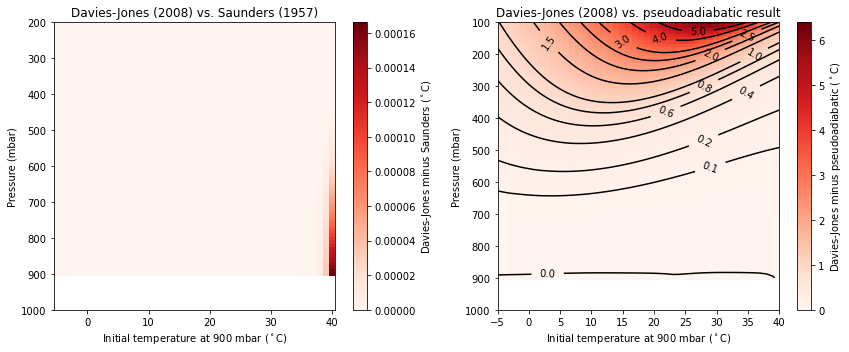

In [197]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
mesh = ax.pcolormesh(
    t_initial, pressure, (t_dj.to(units.kelvin) - t_s), shading='nearest',
    cmap='Reds')
cbar = plt.colorbar(mesh)
cbar.set_label('Davies-Jones minus Saunders ($^\circ$C)')
ax.set_ylim([1000, 200])
ax.set(
    xlabel='Initial temperature at 900 mbar ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title='Davies-Jones (2008) vs. Saunders (1957)')

ax = fig.add_subplot(122)
mesh = ax.pcolormesh(
    t_initial, pressure, t_dj.to(units.kelvin) - t_pseudo_fast.to(units.kelvin),
    shading='nearest', cmap='Reds')
cbar = plt.colorbar(mesh)
cbar.set_label('Davies-Jones minus pseudoadiabatic ($^\circ$C)')
contour = ax.contour(
    t_initial, pressure, t_dj.to(units.kelvin) - t_pseudo_fast.to(units.kelvin),
    [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0], colors='k')
ax.clabel(contour, fmt='%.1f')
ax.set_ylim([1000, 100])
ax.set(
    xlabel='Initial temperature at 900 mbar ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title='Davies-Jones (2008) vs. pseudoadiabatic result')

fig.tight_layout()
# fig.savefig(
#     '/Users/tschanzer/OneDrive - UNSW/UNSW2021/T3/ToR/'
#     'davies-jones_2008_equation_check/solution_check.pdf', facecolor='w',
#     bbox_inches='tight')
plt.show()